In [ ]:
from google.colab import files
uploaded = files.upload()

Saving segmentation data.csv to segmentation data.csv


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats

In [ ]:
df = pd.read_csv('segmentation data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


In [ ]:
df.shape

(2000, 8)

In [ ]:
df.head(10)

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1
5,100000006,0,0,35,1,144848,0,0
6,100000007,0,0,53,1,156495,1,1
7,100000008,0,0,35,1,193621,2,1
8,100000009,0,1,61,2,151591,0,0
9,100000010,0,1,28,1,174646,2,0


We can see that the feature ID is the unique feature so we can drop it down below

In [ ]:
col_name = "ID"
df = df.drop(col_name, axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 109.5 KB


In [ ]:
num_columns = ['Age','Income']
cat_columns = ['Sex','Marital status','Education','Occupation','Settlement size']

df[cat_columns] = df[cat_columns].astype('str')

In [ ]:
df.describe(include='object').T

,count,unique,top,freq
Sex,2000,2,0,1086
Marital status,2000,2,0,1007
Education,2000,4,1,1386
Occupation,2000,3,1,1113
Settlement size,2000,3,0,989


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,2000.0,35.909,11.719402,18.0,27.00,33.0,42.00,76.0
Income,2000.0,120954.419,38108.824679,35832.0,97663.25,115548.5,138072.25,309364.0


DATA PREPROCESSING

Check if there is any null value in dataset?

In [ ]:
df.isnull().sum()

Sex                0
Marital status     0
Age                0
Education          0
Income             0
Occupation         0
Settlement size    0
dtype: int64

- We can see there is no null value in the dataset

We should check if there is any duplicate value in dataset?

In [ ]:
rows_before = len(df)
df.drop_duplicates(inplace=True)
rows_after = len(df)

print(f"Number of duplicate rows: {rows_before - rows_after}")

Number of duplicate rows: 0


- We can see that there is no duplicate value in the dataset.

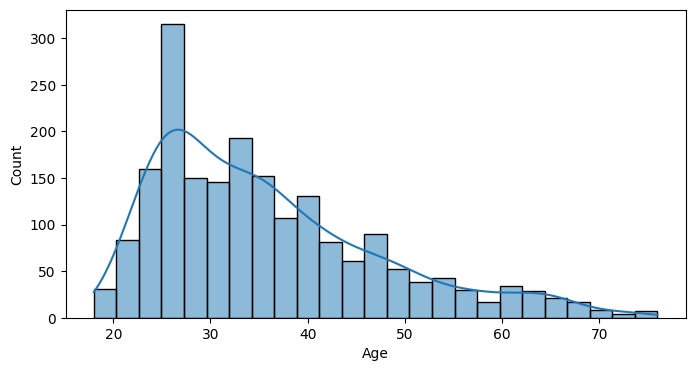

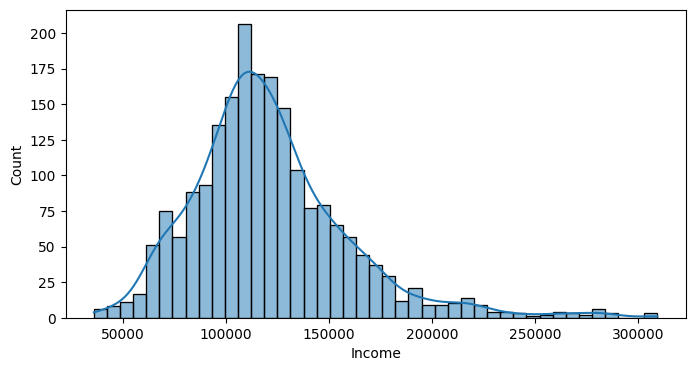

In [ ]:
for num_col in num_columns:
    fig, axs = plt.subplots(figsize=(8,4))
    sns.histplot(df, x=num_col, kde=True)
    plt.show()

- Ta có thể thấy các đặc trưng age và income dường như có độ lệch phải khá nặng, nên khi áp dụng ta cần cẩn thận tùy chỉnh với mô hình mà ta chọn.

And now we visualize the scatter feature "Age" and feature "Income"

<Axes: xlabel='Income', ylabel='Age'>

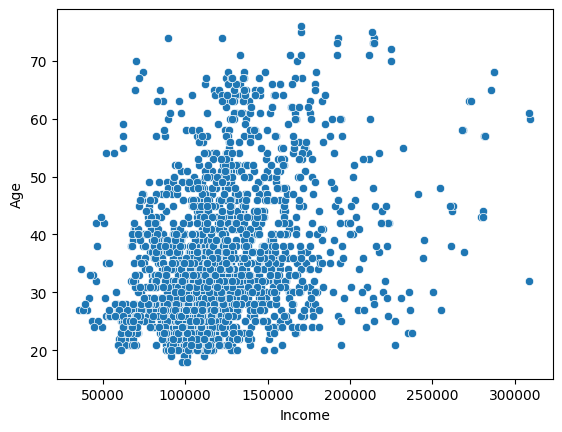

In [ ]:
sns.scatterplot(x="Income",y="Age",data=df)

- Khi quan sát, ta thấy dường như đặc trưng age và income có độ tương quan thấp với nhau.

Text(0.5, 1.0, 'Income')

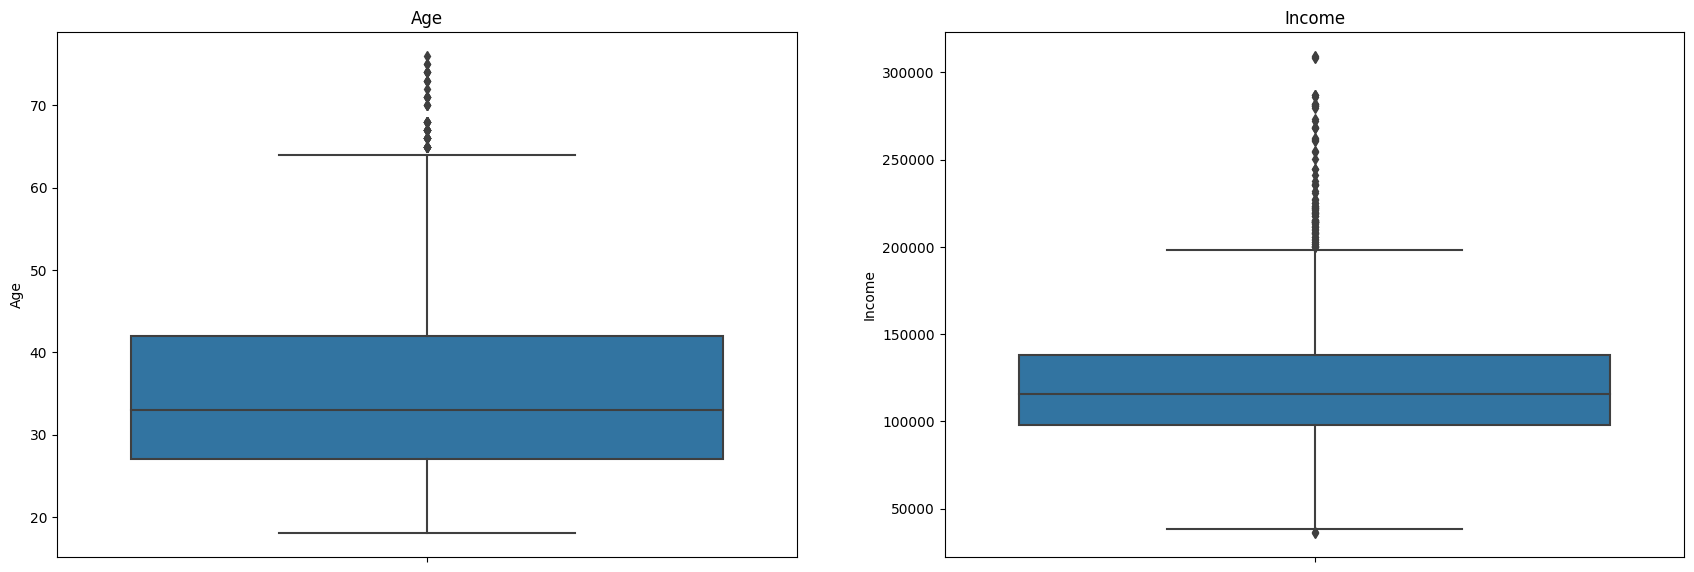

In [ ]:
plt.figure(figsize=(21,15))

plt.subplot2grid((2,2), (0,0))
box1 = sns.boxplot(y=df.Age)
plt.title("Age")

plt.subplot2grid((2,2), (0,1))
box2 = sns.boxplot(y=df.Income)
plt.title("Income")

In [ ]:
# find outlier in all columns
for i in df.select_dtypes(include=['float64','int64']).columns:
  max_thresold=df[i].quantile(0.95)
  min_thresold=df[i].quantile(0.05)
  cus_info=df[(df[i] < max_thresold) & (df[i] > min_thresold)].shape
  print(" outlier in ",i,"is" ,int(((df.shape[0]-cus_info[0])/df.shape[0])*100),"%")

 outlier in  Age is 11 %
 outlier in  Income is 10 %


Ta có thể nhìn thấy được với 2 biến numberical gồm 2 đặc trưng là "Age" và "Income" thì có thể thấy được 1 số ngoại lai ở đây.
Tuy nhiên, khi ta phân tích có thể thấy được rằng:
+ Với dữ liệu của đặc trưng "Age", thì với các dạng trung tâm thương mại mà có những khách hàng có số tuổi lớn hơn các cận giới hạn của boxplot có thể là các ngoại lai đúng, vì các khách hàng vẫn sẽ có số tuổi cao hơn cận giới hạn đến trung tâm thương mại.
+ Với dữ liệu của đặc trưng "Income", thì các ngoại lai này vẫn có thể đúng tại 1 số người có thu nhập thuộc dạng cao thì đối với cận giới hạn trên như vậy là chưa đủ, ngoài ra cũng sẽ có 1 số khách hàng thuộc dạng khó khăn cho nên các giá trị nằm ngoài cận giới hạn dưới vẫn có thể đúng.
Từ đó có thể đúc kết được lại đối với các giá trị ngoại lai này, sau khi ta phân tích thì không thể loại bỏ được.

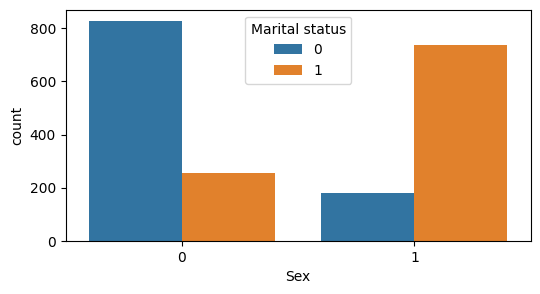

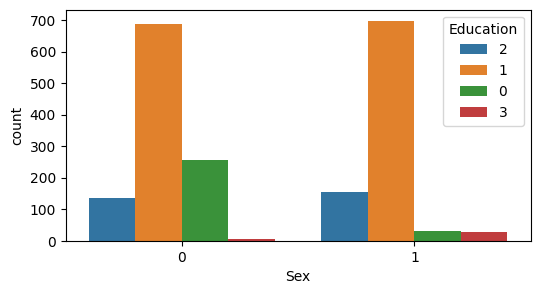

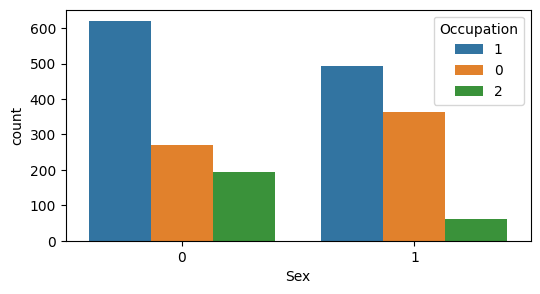

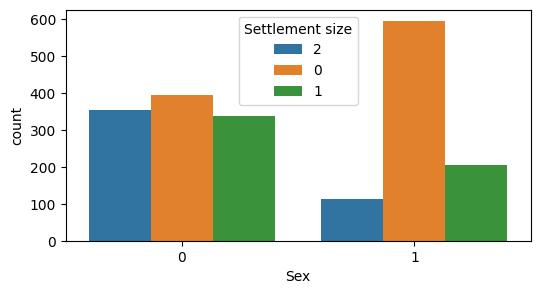

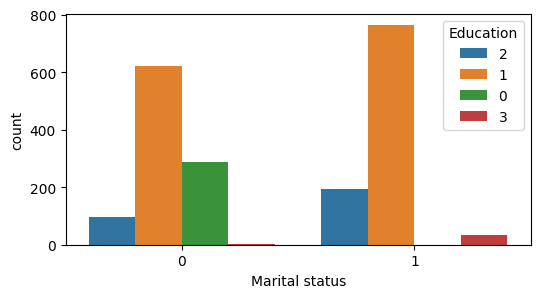

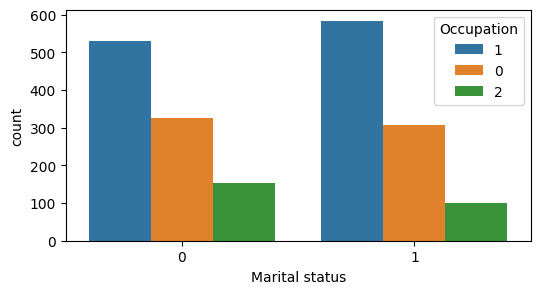

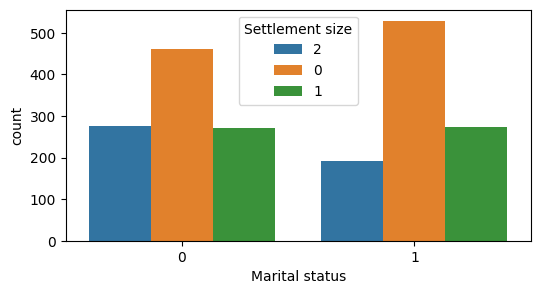

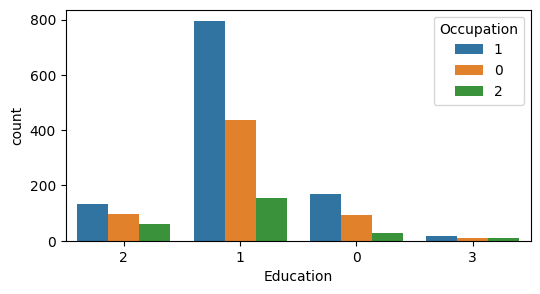

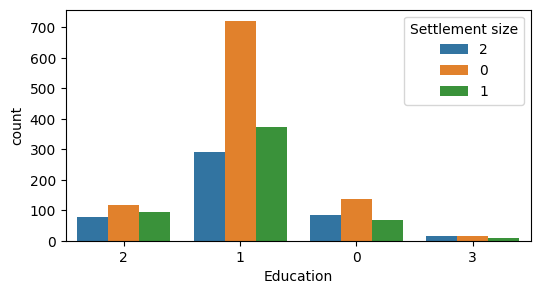

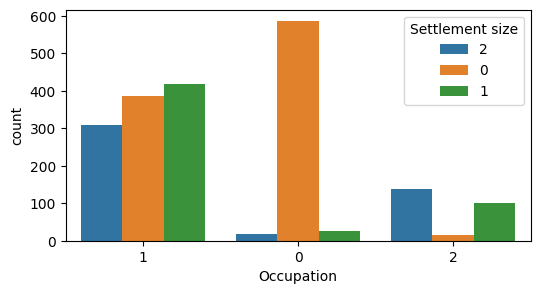

In [ ]:
cat_aux = cat_columns.copy()
for category1 in cat_columns:
    cat_aux.pop(0);
    for category2 in cat_aux:
        if category1 != category2:
            plt.figure(figsize=(6,3))
            sns.countplot(data=df, x=category1, hue=category2)

Với các ảnh thì có 1 số nhận xét như sau:
- Ở đây có thể thấy với đặc trưng là occpation (tình trạng nghề nghiệp) thì có thể thấy với occupation = 0 thì con người sẽ tập trung chủ yếu ở các vùng nhỏ với settlement size = 0
- Về tình trạng học vấn,

In [ ]:
def bivariate_scatter(x, y, hue, df):
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=x, y=y, data=df, hue=hue, alpha=0.85)

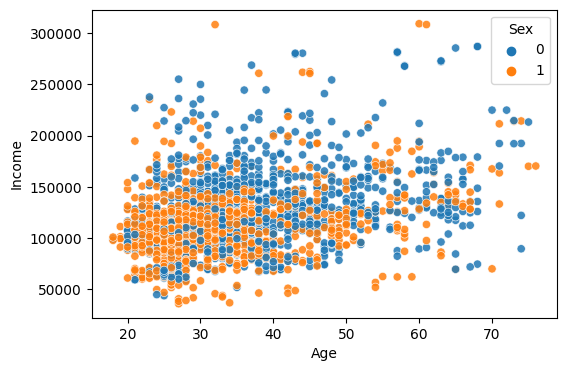

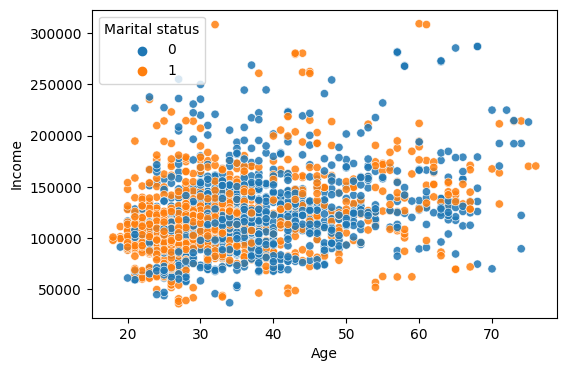

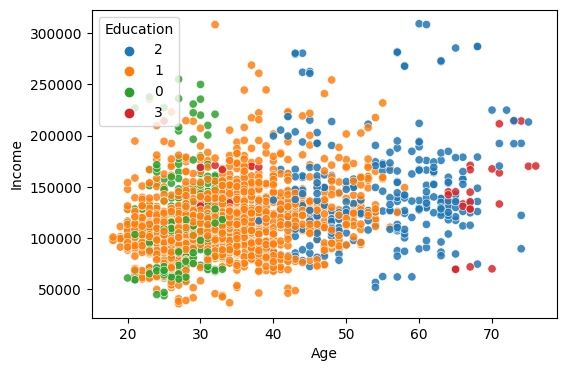

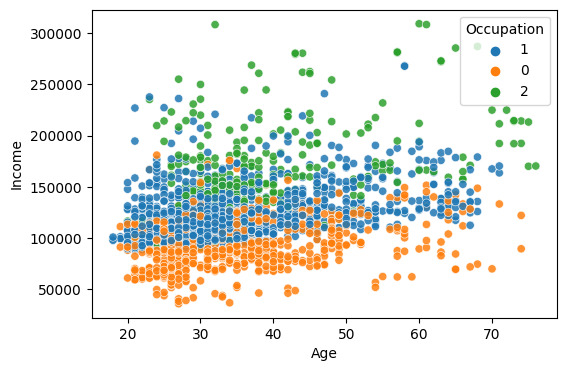

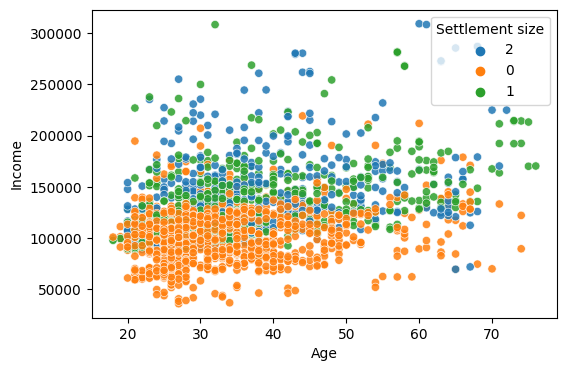

In [ ]:
for cat in cat_columns:
    bivariate_scatter('Age', 'Income', cat, df)

Có thể thấy rằng hiện tại thì như đã trực quan hóa phía trên, ta có thể thấy hiện tại là đặc trưng "Age" và đặc trưng "Income" đang bị lệch phải khá nặng. Nên bây giờ, ta sẽ thử kiểm tính toán bằng thư viện scipy để có thể khẳng định rằng các đặc trưng đó hiện tại không được phân phối bình thường.

Huấn luyện mô hình

In [ ]:
normaltest_result_income = stats.normaltest(df['Income'])[1]
normaltest_result_age    = stats.normaltest(df['Age'])[1]

print(f'The p-value for the null hypothesis of the Income being Normally distributed is {normaltest_result_income}')
print(f'The p-value for the null hypothesis of the Age    being Normally distributed is {normaltest_result_age}')

The p-value for the null hypothesis of the Income being Normally distributed is 2.5009638879187734e-98
The p-value for the null hypothesis of the Age    being Normally distributed is 3.3428344869999675e-56


Sơ lược về hàm stats.normaltest:
Giá trị p-value thường được sử dụng để đưa ra quyết định về việc có thể bác bỏ giả thiết không tuân theo phân phối chuẩn hay không.
+ Nếu p-value < mức ý nghĩa (thường là 0.05), ta có thể bác bỏ giả thiết không tuân theo phân phối chuẩn và kết luận rằng dữ liệu có thể tuân theo phân phối chuẩn.
+ Ngược lại, nếu p-value >= 0.05, không có đủ bằng chứng để bác bỏ giả thiết, và chúng ta không có đủ thông tin để kết luận về việc dữ liệu có tuân theo phân phối chuẩn hay không.

Cho nên từ các kết luận trên ta có thể thấy được rằng:
+ Giá trị p-value ở đây lần lượt là: p-value(Income) < p-value(Age) < 0,05. Từ đây ta có thể bác bỏ được giả thiết không tuân theo phân phối chuẩn, và có thể đưa ra quyết định chuẩn hóa (normalize) dữ liệu để đảm bảo rằng nó tuân theo phân phối chuẩn.


Ta bắt đầu biến đổi các đặc trưng "Income" và "Age".
Ở đây,

In [ ]:
def apply_log(column):
    return np.log(column)

def normality_test(column):
    return stats.normaltest(column)

In [ ]:
from sklearn.preprocessing import PowerTransformer

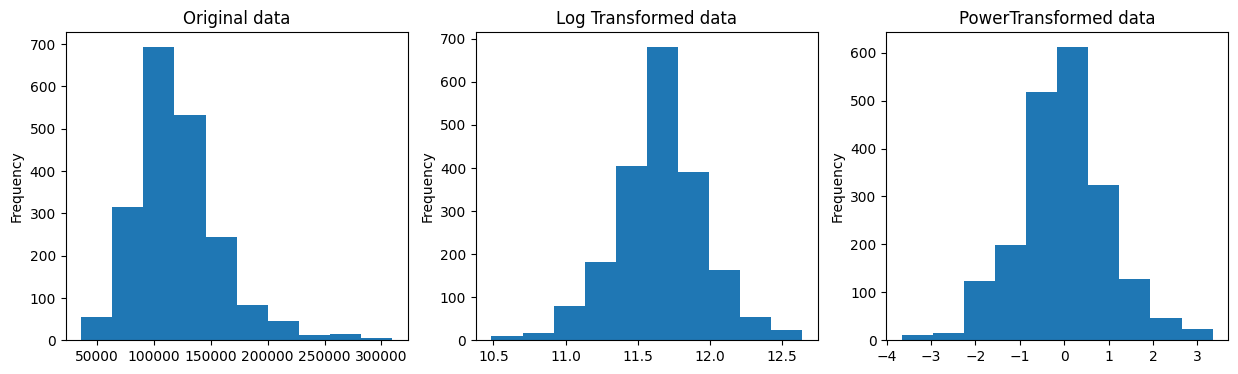

In [ ]:
# PowerTransform data
feature = df['Income'].to_numpy().reshape(-1,1)

powtr = PowerTransformer()
feature_transf = powtr.fit_transform(feature)
array_1d = feature_transf.flatten()
feature = pd.Series(data=array_1d, index=list(range(len(array_1d))))

# Log Transform data
log_transformed_income = apply_log(df['Income'])

# Create axis for original data plot (ax1) and transformed data (ax2)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4));

# Plot original data & get metrics
df['Income'].plot(kind='hist', ax=ax1)
ax1.title.set_text('Original data')
norm_test1 = normality_test(df['Income'])

# Plot log transformed data & get metrics
log_transformed_income.plot(kind='hist', ax=ax2);
ax2.title.set_text('Log Transformed data')
norm_test2 = normality_test(log_transformed_income)

# Plot power transformed data & get metrics
feature.plot(kind='hist', ax=ax3);
ax3.title.set_text('PowerTransformed data')
norm_test3 = normality_test(feature)

# Create a DataFrame that shows normality test results for each tranformation
norm_results = [norm_test1, norm_test2, norm_test3]
metrics = pd.DataFrame(norm_results, index=['Original data', 'Log transform', 'PowerTransformer'])

In [ ]:
normality_test(log_transformed_income)

NormaltestResult(statistic=32.357037046565075, pvalue=9.41366371618838e-08)

In [ ]:
metrics

,statistic,pvalue
Original data,449.473326,2.500964e-98
Log transform,32.357037,9.413664e-08
PowerTransformer,27.859212,8.921730e-07


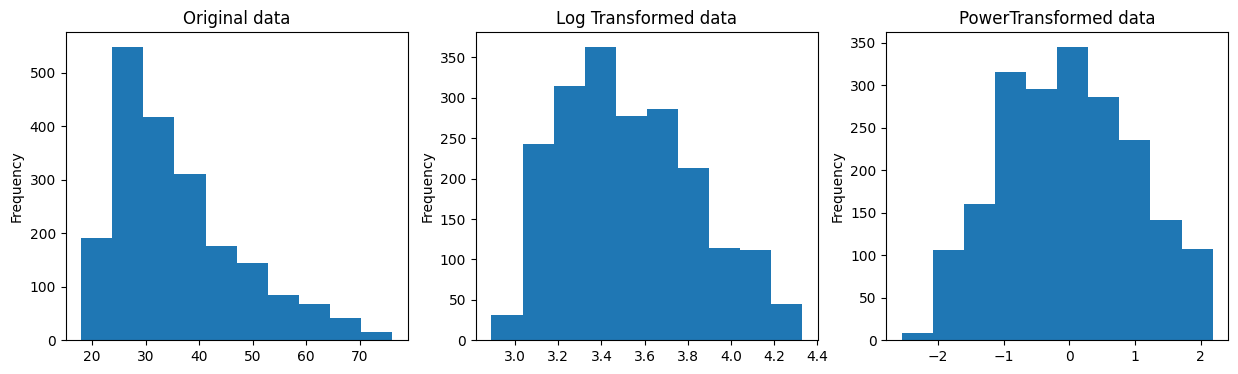

In [ ]:
# PowerTransform data
feature2 = df['Age'].to_numpy().reshape(-1,1)

powtr = PowerTransformer()
feature_transf = powtr.fit_transform(feature2)
array_1d = feature_transf.flatten()
feature2 = pd.Series(data=array_1d, index=list(range(len(array_1d))))

# Log Transform data
log_transformed_age = apply_log(df['Age'])

# Create axis for original data plot (ax1) and transformed data (ax2)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4));

# Plot original data & get metrics
df['Age'].plot(kind='hist', ax=ax1)
ax1.title.set_text('Original data')
norm_test1 = normality_test(df['Age'])

# Plot log transformed data & get metrics
log_transformed_age.plot(kind='hist', ax=ax2);
ax2.title.set_text('Log Transformed data')
norm_test2 = normality_test(log_transformed_age)

# Plot power transformed data & get metrics
feature2.plot(kind='hist', ax=ax3);
ax3.title.set_text('PowerTransformed data')
norm_test3 = normality_test(feature2)

# Create a DataFrame that shows normality test results for each tranformation
norm_results = [norm_test1, norm_test2, norm_test3]
metrics = pd.DataFrame(norm_results, index=['Original data', 'Log transform', 'PowerTransformer'])

In [ ]:
metrics

,statistic,pvalue
Original data,255.475892,3.342834e-56
Log transform,111.094201,7.519703e-25
PowerTransformer,161.196197,9.924088e-36


In [ ]:
df['transf_income'] = feature
df['transf_age']    = log_transformed_age

In [ ]:
customer_info_transformed = df.drop(['Income', 'Age'], axis=1)
customer_info_transformed

,Sex,Marital status,Education,Occupation,Settlement size,transf_income,transf_age
0,0,0,2,1,2,0.239545,4.204693
1,1,1,1,1,2,0.869781,3.091042
2,0,0,1,0,0,-0.846121,3.891820
3,0,0,1,1,1,1.303766,3.806662
4,0,0,1,1,1,0.830970,3.970292
...,...,...,...,...,...,...,...
1995,1,0,1,0,0,0.209208,3.850148
1996,1,1,1,1,0,0.051991,3.295837
1997,0,0,0,0,0,-0.948374,3.433987
1998,1,1,1,0,0,-0.545364,3.178054


In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(customer_info_transformed)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

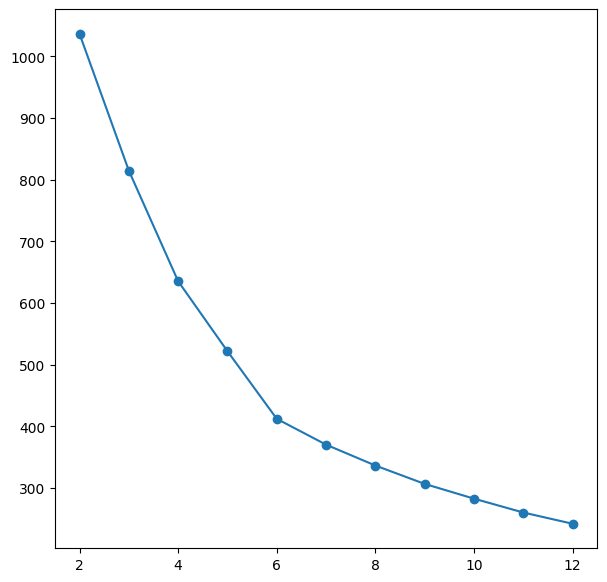

In [ ]:
clusters_range=[2,3,4,5,6,7,8,9,10,11,12]
inertias=[]

for c in clusters_range:
    kmeans=KMeans(n_clusters=c, random_state=0).fit(X)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(7,7))
plt.plot(clusters_range,inertias, marker='o')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

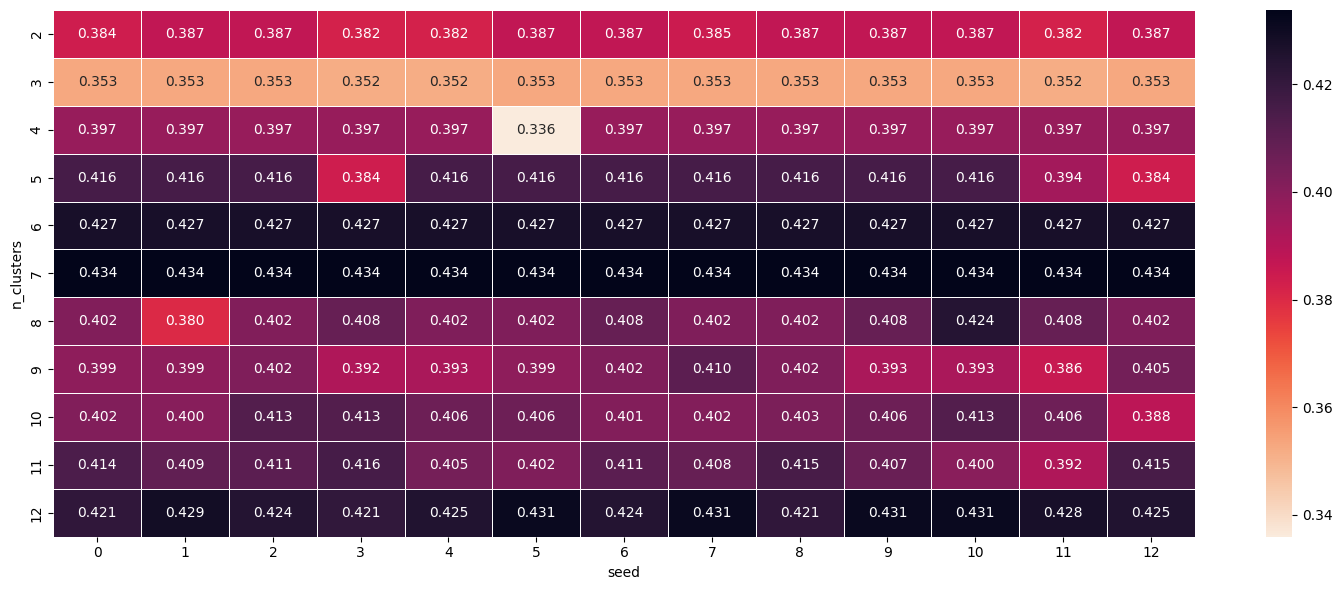

In [ ]:
clusters_range=range(2, 13)
random_range  =range(0, 13)
results=[]

for c in clusters_range:
    for r in random_range:
        clusterer=KMeans(n_clusters=c, random_state=r)
        cluster_labels=clusterer.fit_predict(X)
        silhouette_avg=silhouette_score(X, cluster_labels)
        results.append([c,r,silhouette_avg])

result  =pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km=pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15, 6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X)

In [ ]:
X_pca_df = pd.DataFrame(data=X_pca, columns=['X1', 'X2', 'X3'])

In [ ]:
kmeans=KMeans(n_clusters=6, random_state=0).fit(X)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
labels = kmeans.labels_
X_pca_df['Labels'] = labels

In [ ]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

In [ ]:
X_pca_df

,X1,X2,X3,Labels
0,0.829143,0.350518,-0.162403,3
1,-0.531854,0.719504,-0.230299,2
2,0.489493,-0.693627,0.175269,0
3,0.712487,-0.027906,-0.049583,3
4,0.718334,-0.036815,-0.052850,3
...,...,...,...,...
1995,-0.188657,-0.674905,-0.559832,5
1996,-0.794289,-0.009952,-0.008375,1
1997,0.492095,-0.748275,0.192757,0
1998,-0.881738,-0.282777,0.097842,1


In [ ]:
X_pca_df['Labels'] = X_pca_df['Labels'].astype(str)

In [ ]:
results_df = df.drop(['transf_income', 'transf_age'], axis=1)
results_df['Labels'] = kmeans.labels_
results_df = results_df.astype({'Sex':'int32', 'Marital status':'int32', 'Education':'int32', 'Occupation':'int32', 'Settlement size':'int32'})
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int32
 1   Marital status   2000 non-null   int32
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int32
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int32
 6   Settlement size  2000 non-null   int32
 7   Labels           2000 non-null   int32
dtypes: int32(6), int64(2)
memory usage: 93.8 KB


In [ ]:
results_df.head(10)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Labels
0,0,0,67,2,124670,1,2,3
1,1,1,22,1,150773,1,2,2
2,0,0,49,1,89210,0,0,0
3,0,0,45,1,171565,1,1,3
4,0,0,53,1,149031,1,1,3
5,0,0,35,1,144848,0,0,0
6,0,0,53,1,156495,1,1,3
7,0,0,35,1,193621,2,1,3
8,0,1,61,2,151591,0,0,4
9,0,1,28,1,174646,2,0,4


Cụm 0

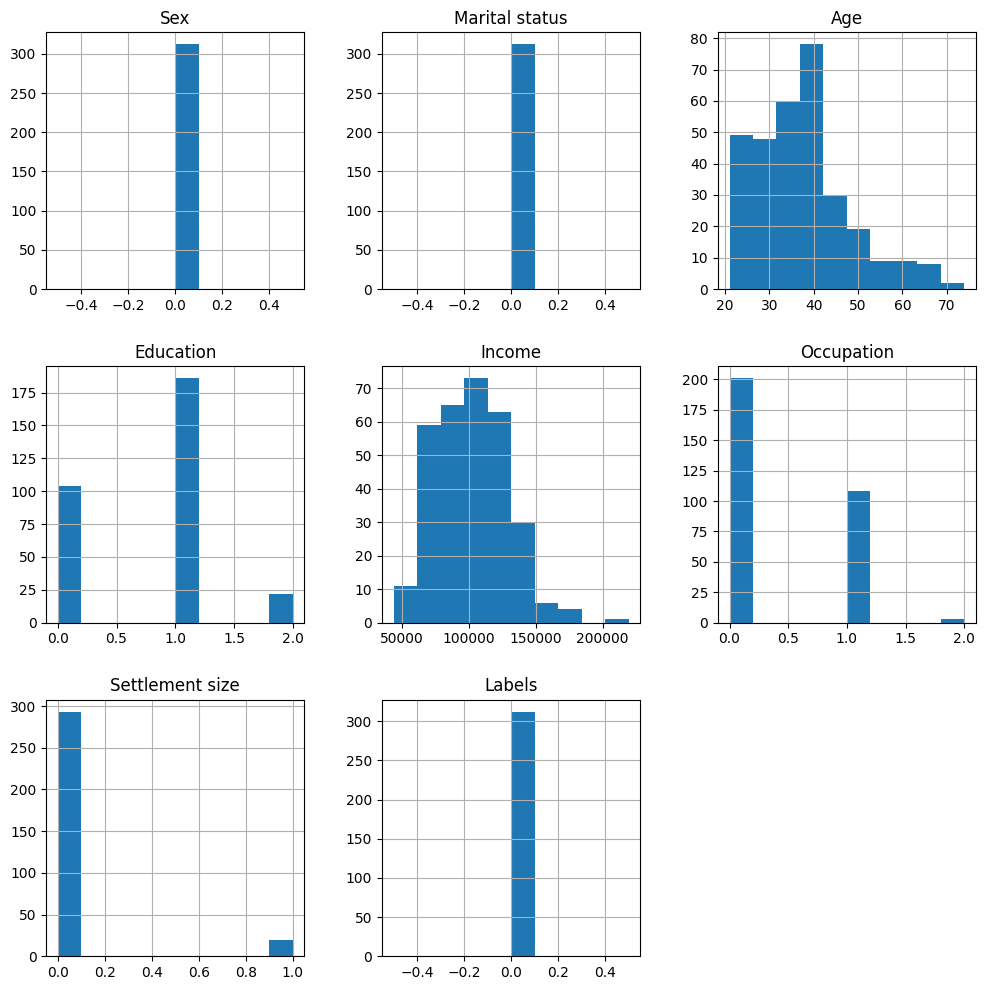

In [ ]:
results_df[results_df['Labels'] == 0].hist(figsize=(12, 12));

Cụm 1

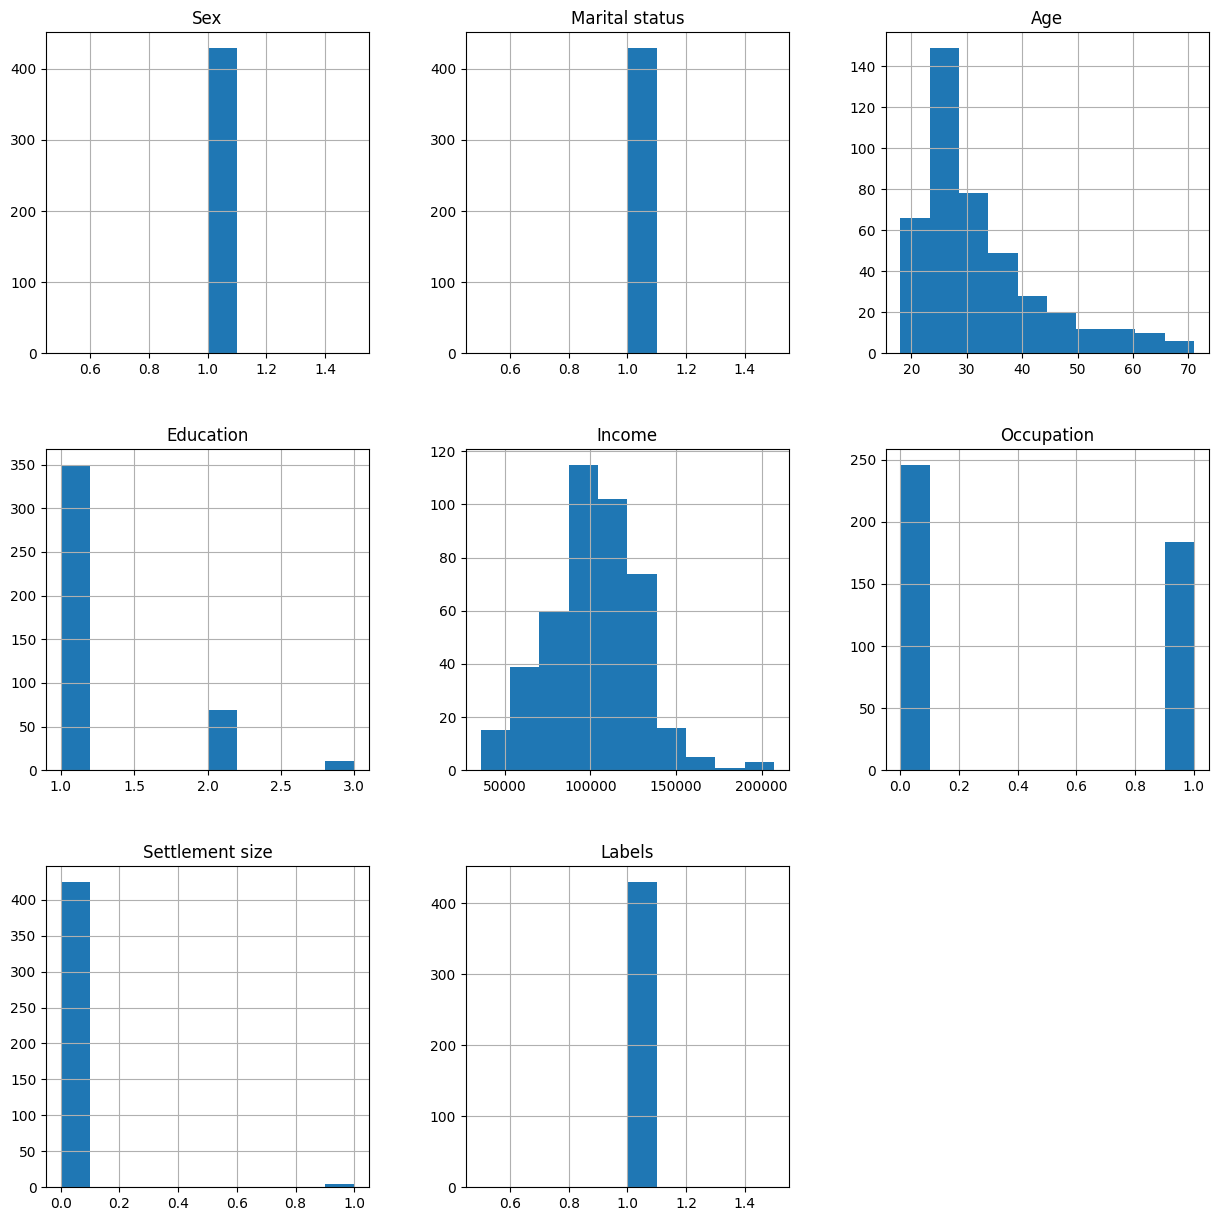

In [ ]:
results_df[results_df['Labels'] == 1].hist(figsize=(15,15));

Cụm2

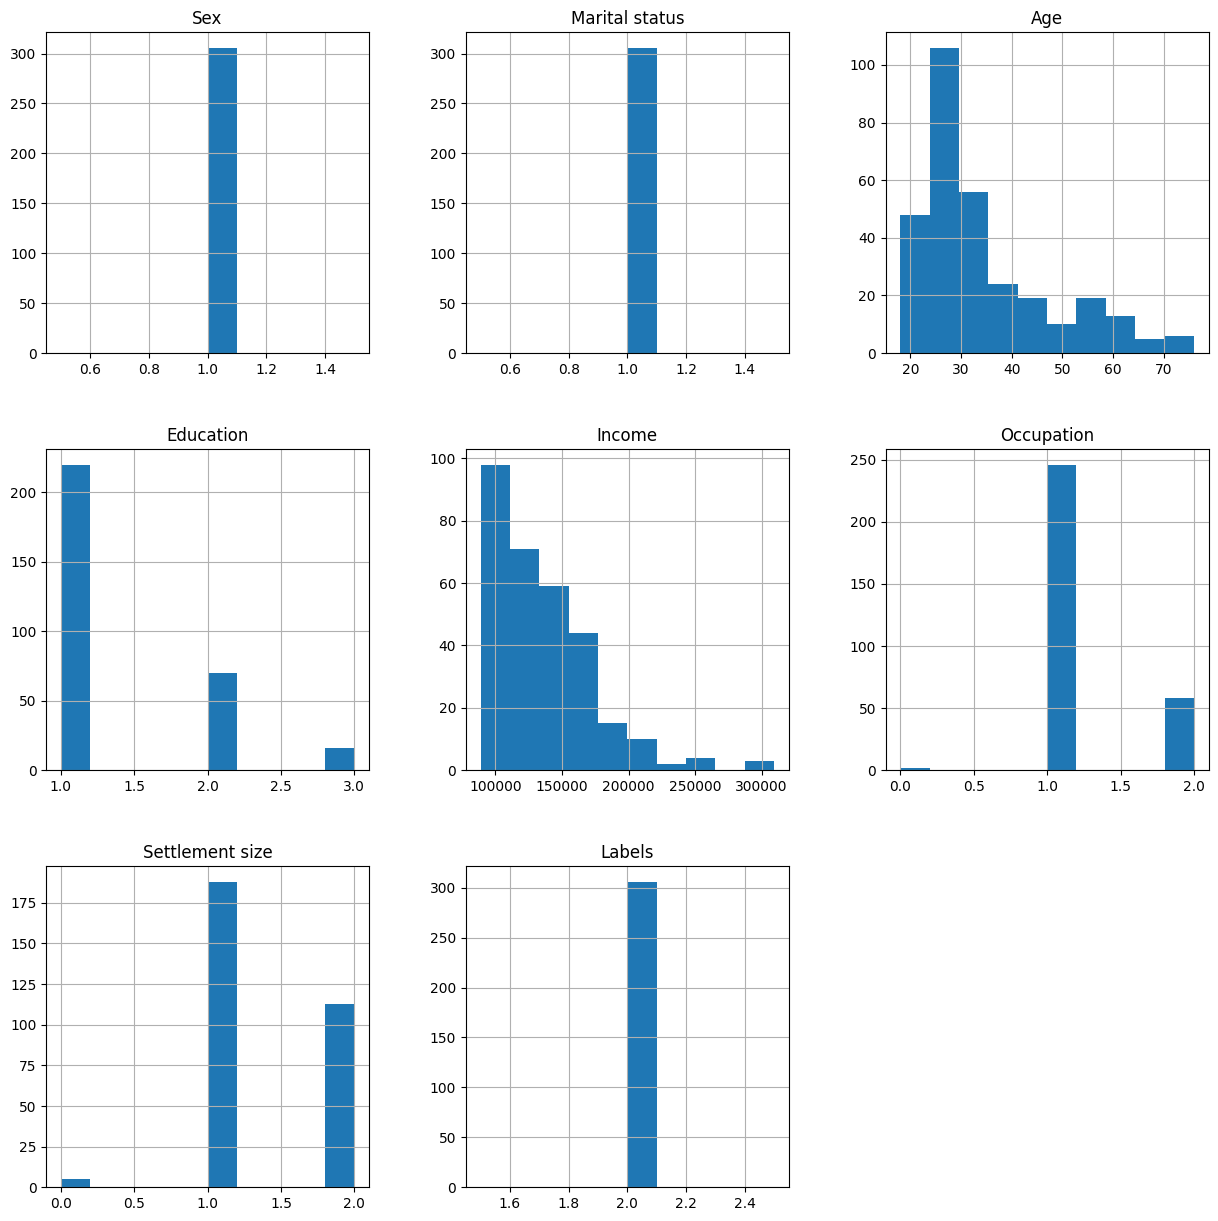

In [ ]:
results_df[results_df['Labels'] == 2].hist(figsize=(15,15));

Cụm 3

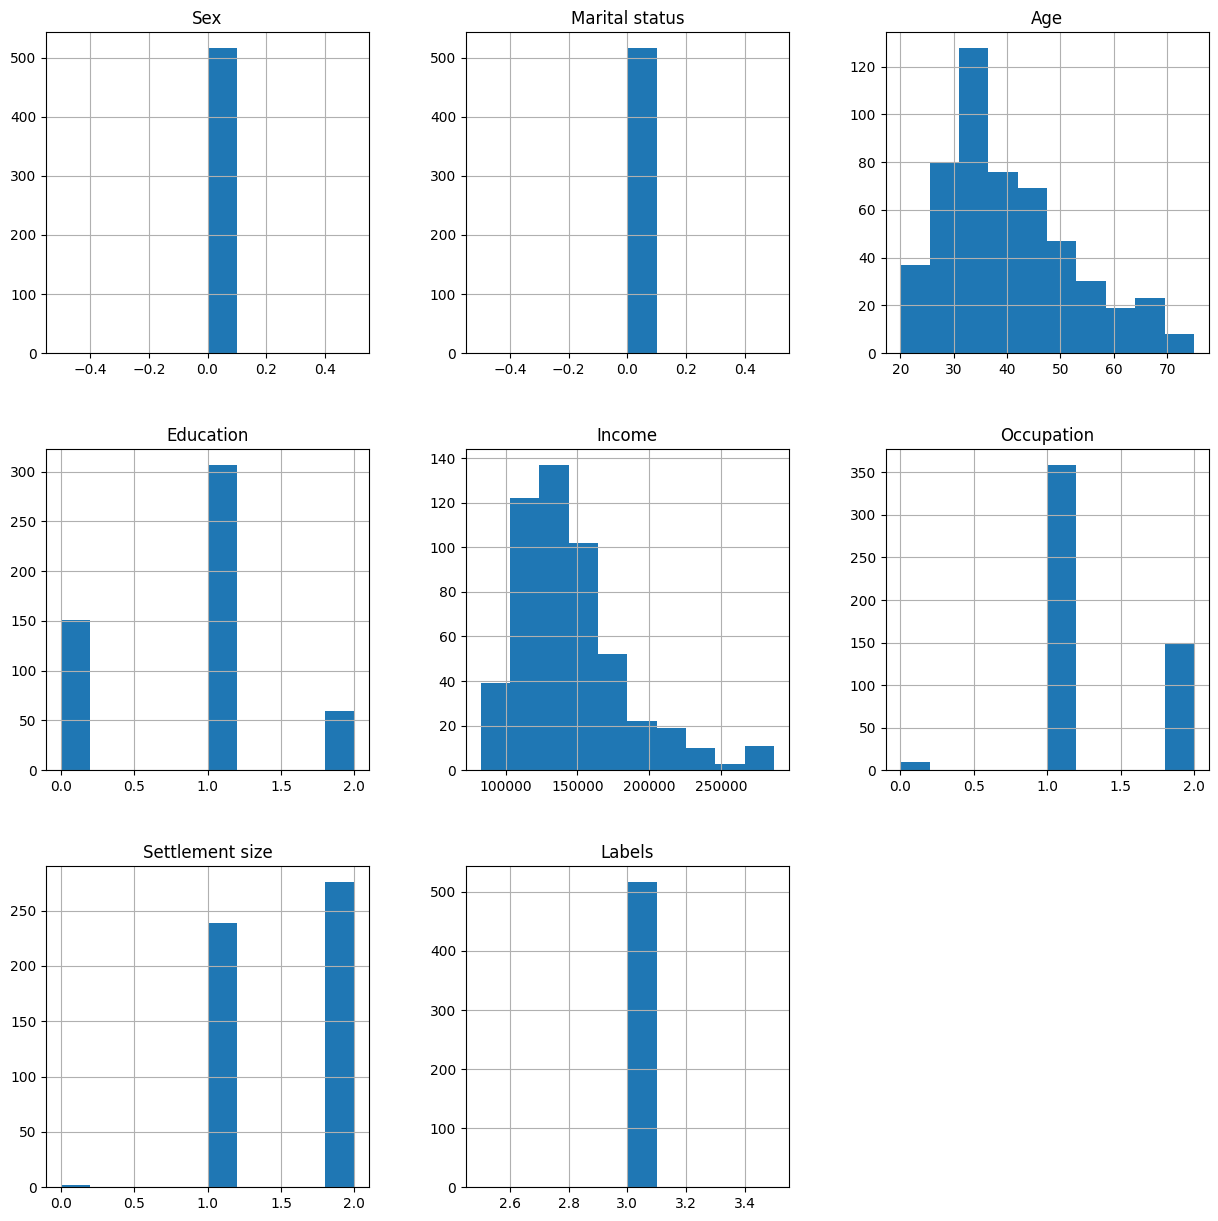

In [ ]:
results_df[results_df['Labels'] == 3].hist(figsize=(15,15));

Cụm 4

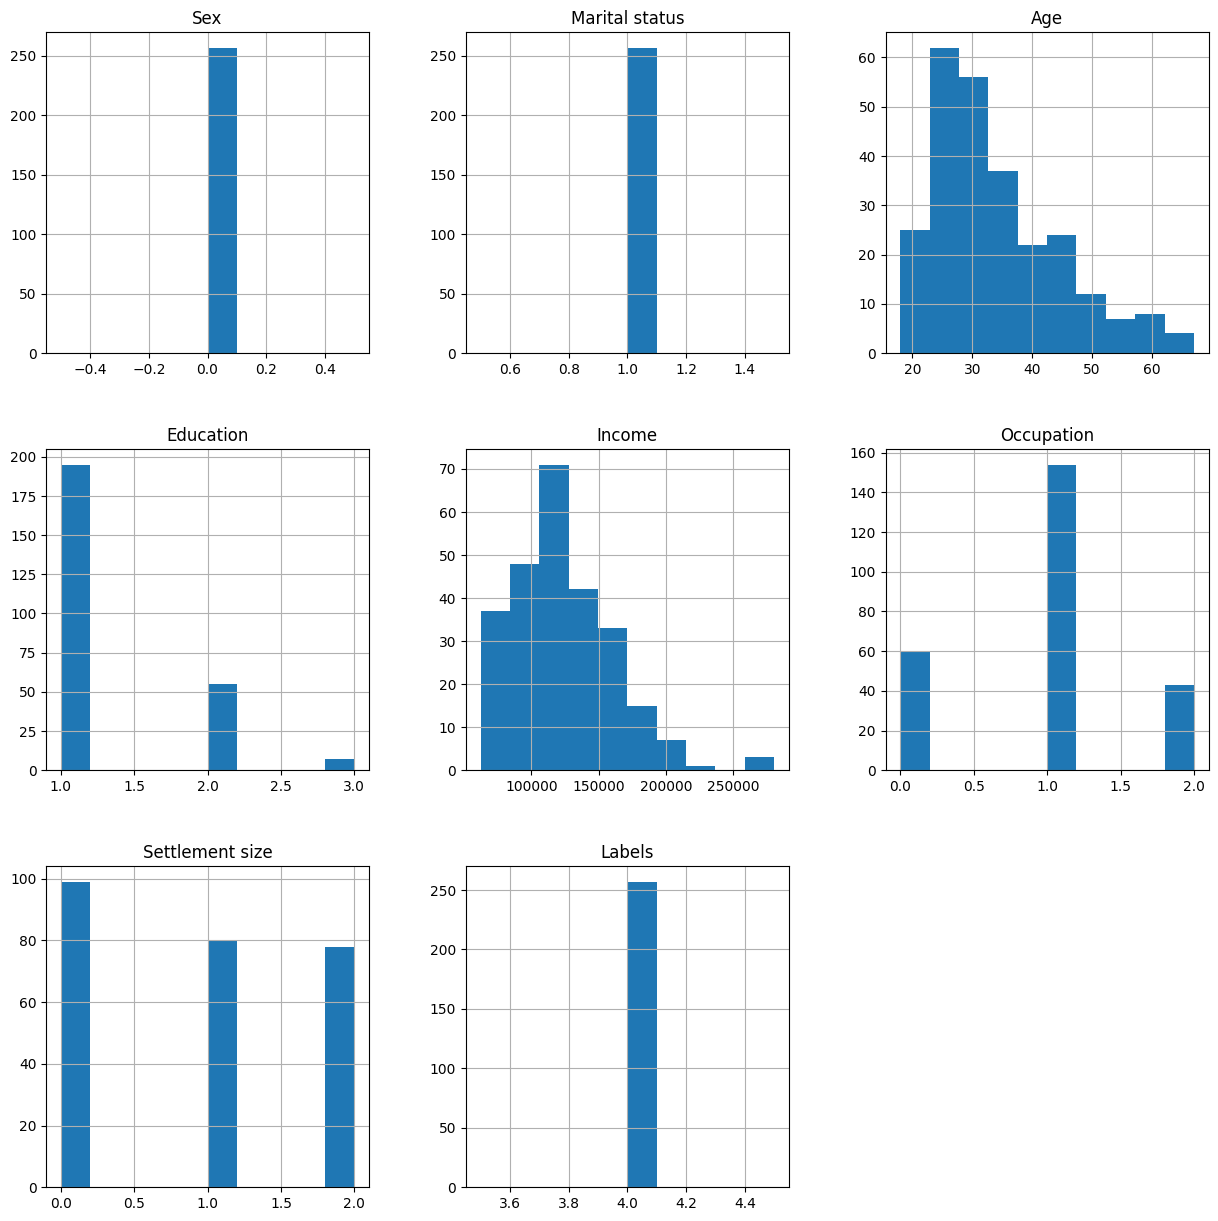

In [ ]:
results_df[results_df['Labels'] == 4].hist(figsize=(15,15));

Cụm 5

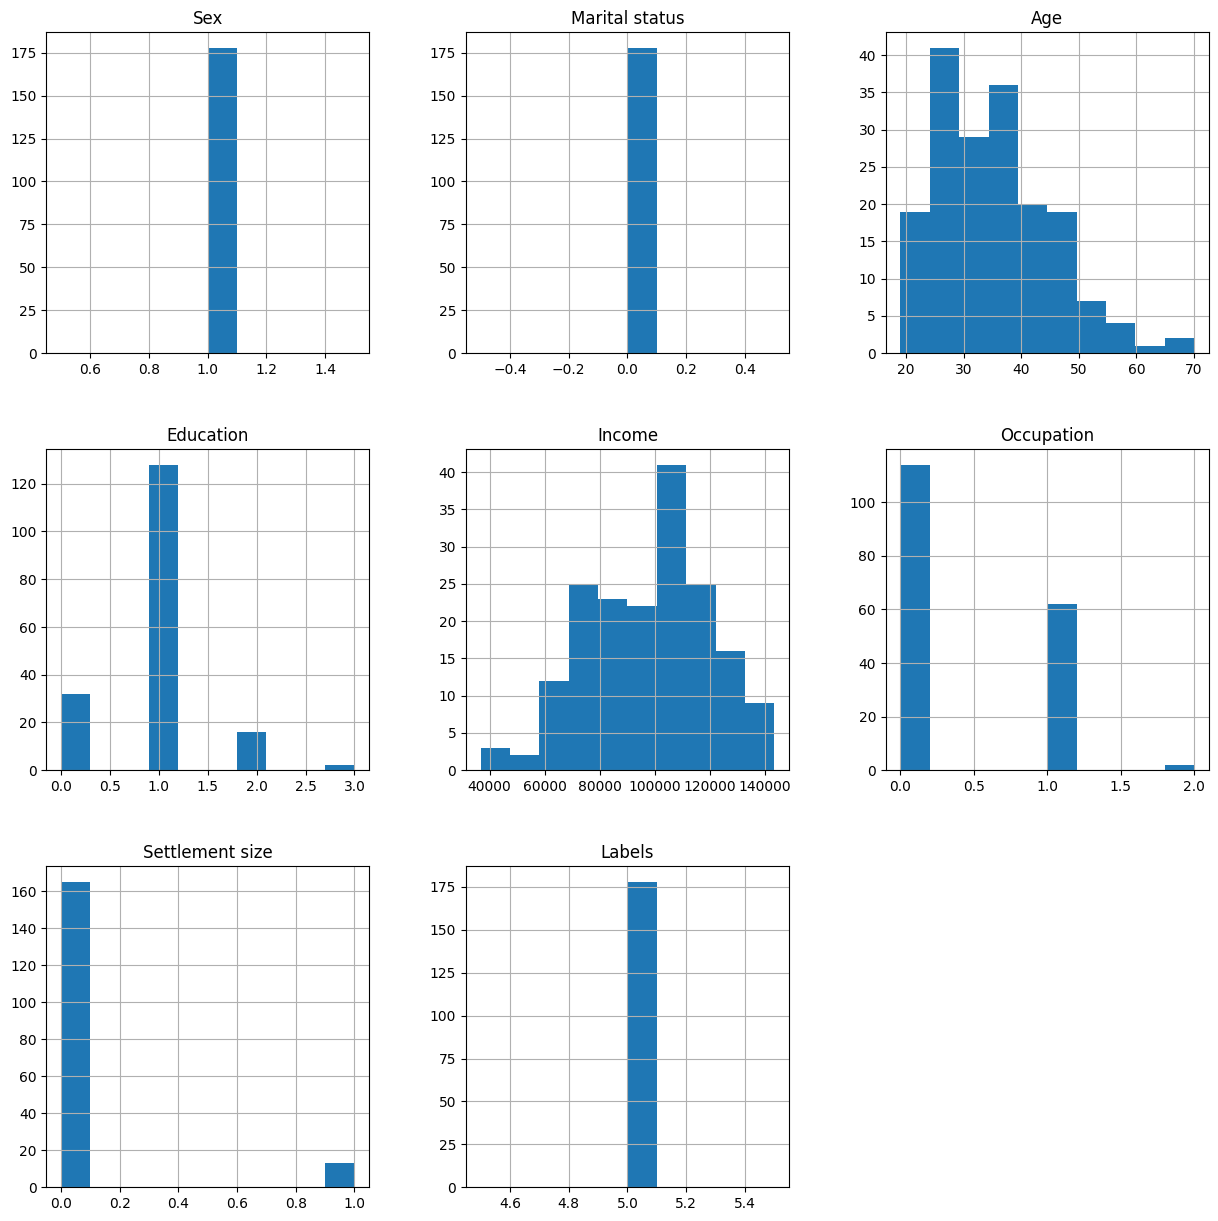

In [ ]:
results_df[results_df['Labels'] == 5].hist(figsize=(15,15));

In [ ]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns = results_df.columns[:7], index = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5'])

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
C0,3.885781e-16,1.332268e-15,0.245726,0.182692,0.030449,0.451144,0.484804
C1,1.000000e+00,1.000000e+00,0.403876,0.213953,0.005814,0.448891,0.375836
C2,1.000000e+00,1.000000e+00,0.444444,0.591503,0.676471,0.585119,0.405291
C3,2.553513e-15,1.776357e-15,0.274017,0.633462,0.764990,0.615822,0.524984
C4,-3.885781e-16,1.000000e+00,0.422827,0.466926,0.459144,0.530253,0.409658
C5,1.000000e+00,1.498801e-15,0.310861,0.185393,0.036517,0.433188,0.439125
